# Imports

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


# Data generation

In [2]:
def draw_circle(N, domainLength, x_center, y_center, diameter):
    domain = np.ones((N,N))
    radius = diameter / 2
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (X - x_center)**2 + (Y - y_center)**2 <= radius**2
    domain[mask] = -1
    return domain

def draw_square(N, domainLength, x_center, y_center, side_length):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    mask = (np.abs(X - x_center) <= side_length/2) & (np.abs(Y - y_center) <= side_length/2)
    domain[mask] = -1
    return domain

def draw_triangle(N, domainLength, x_center, y_center, height):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)
    
    # Height of the equilateral triangle
    side_length = 2 / np.sqrt(3) * height
    
    # Calculate vertices of the triangle
    v_top = (x_center, y_center - 2 * height / 3)                # Top vertex
    v_left = (x_center - side_length / 2, y_center + height / 3)  # Bottom left vertex
    v_right = (x_center + side_length / 2, y_center + height / 3) # Bottom right vertex
    
    # Create mask for points inside the triangle using cross products
    mask = (
        ((X - v_top[0]) * (v_left[1] - v_top[1]) - (Y - v_top[1]) * (v_left[0] - v_top[0]) >= 0) &
        ((X - v_left[0]) * (v_right[1] - v_left[1]) - (Y - v_left[1]) * (v_right[0] - v_left[0]) >= 0) &
        ((X - v_right[0]) * (v_top[1] - v_right[1]) - (Y - v_right[1]) * (v_top[0] - v_right[0]) >= 0)
    )
    
    domain[mask] = -1
    return domain

def draw_cross(N, domainLength, x_center, y_center, arm_length):
    domain = np.ones((N,N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    X, Y = np.meshgrid(x, y)

    arm_width = arm_length / 3

    # Create masks for the vertical and horizontal bars of the cross
    vertical_bar = (np.abs(X - x_center) <= arm_width/2) & (np.abs(Y - y_center) <= arm_length/2)
    horizontal_bar = (np.abs(X - x_center) <= arm_length/2) & (np.abs(Y - y_center) <= arm_width/2)
    
    # Combine the masks to form the cross
    mask = vertical_bar | horizontal_bar
    domain[mask] = -1
    return domain

# Function to generate either a circle, a square or a triangle
def generate_shapes(N, domainLength, min_max_side_length, shape=None):
    if shape is None:
        shape = np.random.randint(0, 4)  # Random shape type between 0 and 3
    
    if shape == 0:  # Circle
        diameter = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(diameter/2, domainLength - diameter/2)
        y_center = np.random.uniform(diameter/2, domainLength - diameter/2)
        domain = draw_circle(N, domainLength, x_center, y_center, diameter)
    
    elif shape == 1:  # Square
        side_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(side_length/2, domainLength - side_length/2)
        y_center = np.random.uniform(side_length/2, domainLength - side_length/2)
        domain = draw_square(N, domainLength, x_center, y_center, side_length)

    elif shape == 2:  # Triangle
        height = np.random.uniform(*min_max_side_length)
        side_length = 2 / np.sqrt(3) * height
        x_center = np.random.uniform(side_length/2, domainLength - side_length/2)
        y_center = np.random.uniform(side_length/2, domainLength - side_length/2)
        domain = draw_triangle(N, domainLength, x_center, y_center, height)

    else:  # Cross
        arm_length = np.random.uniform(*min_max_side_length)
        x_center = np.random.uniform(arm_length/2, domainLength - arm_length/2)
        y_center = np.random.uniform(arm_length/2, domainLength - arm_length/2)
        domain = draw_cross(N, domainLength, x_center, y_center, arm_length)

    return domain, shape


(1280, 1, 64, 64)
(1280, 1, 64, 64)
(1280, 1, 64, 64)
(1280, 1, 64, 64)


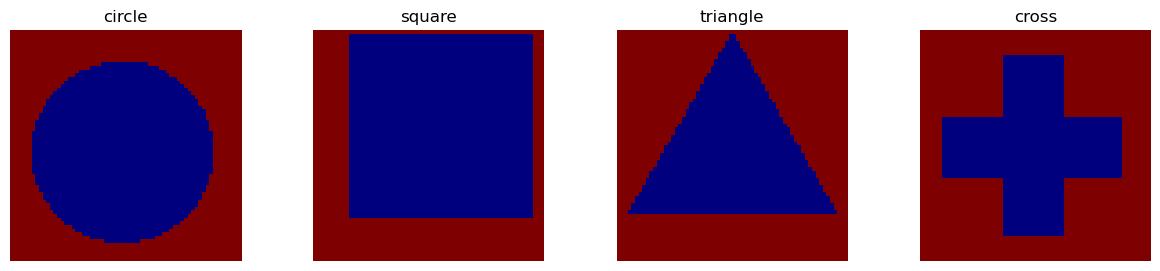

In [3]:

N = 64
domainLength = 1
numberOfCircles = 5
radius = 0.12
min_max_side_length = (0.8, 0.8)

np.random.seed(0)

numberOfSamples = 1280 # 640? #1280
numberOfAnomolousSamples = 128
    
circles = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 0)
    circles[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(circles).to(torch.float32), f"data/circleData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/circleLabels{N}.pt")

squares = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 1)
    squares[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(squares).to(torch.float32), f"data/squareData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/squareLabels{N}.pt")

triangles = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 2)
    triangles[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(triangles).to(torch.float32), f"data/triangleData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/triangleLabels{N}.pt")

crosses = np.zeros((numberOfSamples, 1, N, N))
shapes = np.zeros((numberOfSamples, 1))
for k in range(numberOfSamples):
    domain, shape = generate_shapes(N, domainLength, min_max_side_length, 3)
    crosses[k, 0] = domain
    shapes[k] = shape
torch.save(torch.from_numpy(crosses).to(torch.float32), f"data/crossData{N}.pt")
torch.save(torch.from_numpy(shapes).to(torch.float32), f"data/crossLabels{N}.pt")

# Plot each shape type and save the figure as eps without axes
labels = ['circle', 'square', 'triangle', 'cross']
samples_list = [circles, squares, triangles, crosses]
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes):
    print(samples_list[i].shape)
    sample = samples_list[i][1].squeeze()
    ax.imshow(sample, cmap='jet')
    ax.set_title(f'{labels[i]}')
    ax.axis('off')
plt.savefig('outputs/shape_samples.pdf', bbox_inches='tight')

# Define training parameters

In [4]:
# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator, ndf//2 to stabilize training
ndf = ngf//2

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 2e-4

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Define dataset

1279
torch.Size([16, 1, 64, 64])


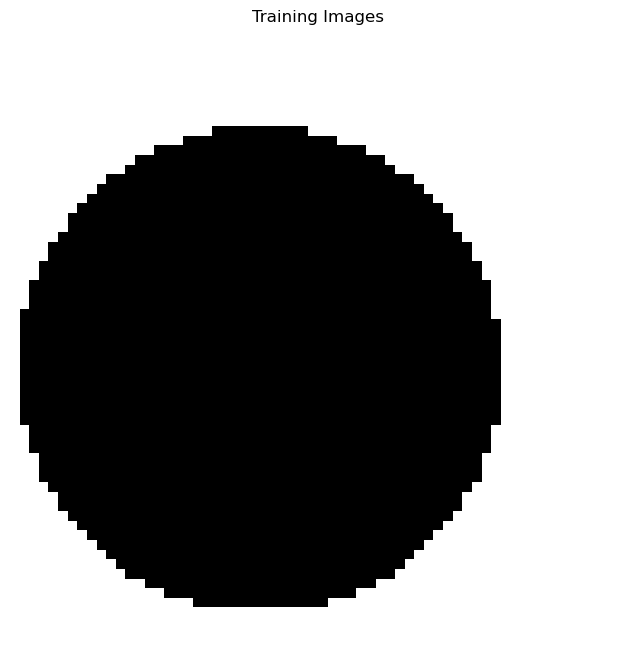

In [5]:
class microstructureDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

data  = torch.load('data/circleData64.pt')
dataset = microstructureDataset(data[1:12800])
print(len(dataset))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch.shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


# Weight initialization

In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define generator architecture

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2,True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


 Now, we can instantiate the generator and apply the `weights_init`

 function. Check out the printed model to see how the generator object is

 structured.



In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)
print(sum([p.numel() for p in netG.parameters()]))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

# Define discriminator architecture

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)
print(sum([p.numel() for p in netD.parameters()]))

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
693632


# Define loss and optimizer

In [11]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop

In [12]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1


Starting Training Loop...
[0/5][0/80]	Loss_D: 1.7132	Loss_G: 1.5869	D(x): 0.5158	D(G(z)): 0.5730 / 0.2210
[0/5][50/80]	Loss_D: 0.0274	Loss_G: 3.8726	D(x): 0.9890	D(G(z)): 0.0160 / 0.0315
[1/5][0/80]	Loss_D: 0.2166	Loss_G: 5.8271	D(x): 0.9670	D(G(z)): 0.1585 / 0.0051
[1/5][50/80]	Loss_D: 0.0280	Loss_G: 5.2004	D(x): 0.9845	D(G(z)): 0.0121 / 0.0118
[2/5][0/80]	Loss_D: 0.1577	Loss_G: 5.0942	D(x): 0.8810	D(G(z)): 0.0177 / 0.0089
[2/5][50/80]	Loss_D: 0.0659	Loss_G: 4.3923	D(x): 0.9713	D(G(z)): 0.0348 / 0.0178
[3/5][0/80]	Loss_D: 0.0410	Loss_G: 5.0418	D(x): 0.9827	D(G(z)): 0.0230 / 0.0081
[3/5][50/80]	Loss_D: 0.3563	Loss_G: 3.1965	D(x): 0.8114	D(G(z)): 0.1245 / 0.0578
[4/5][0/80]	Loss_D: 0.2899	Loss_G: 2.8751	D(x): 0.9204	D(G(z)): 0.1832 / 0.0624
[4/5][50/80]	Loss_D: 0.5172	Loss_G: 3.7299	D(x): 0.6279	D(G(z)): 0.0023 / 0.0358


In [13]:
# Save the model
torch.save(netG.state_dict(), 'outputs/dcgan/netG.pt')
torch.save(netD.state_dict(), 'outputs/dcgan/netD.pt')

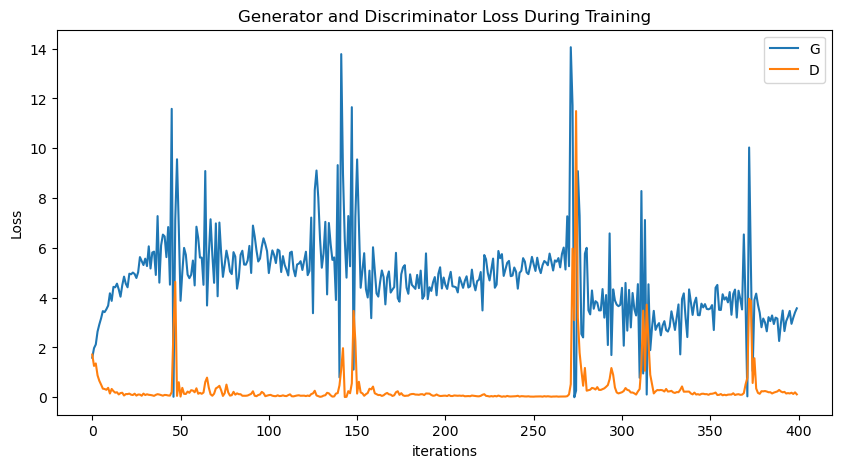

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('outputs/dcgan/loss.png')
plt.show()



MovieWriter ffmpeg unavailable; using Pillow instead.


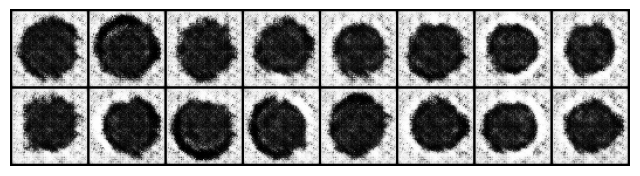

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Save the animation as a gif
ani.save('outputs/dcgan/training_animation.gif')

HTML(ani.to_jshtml())


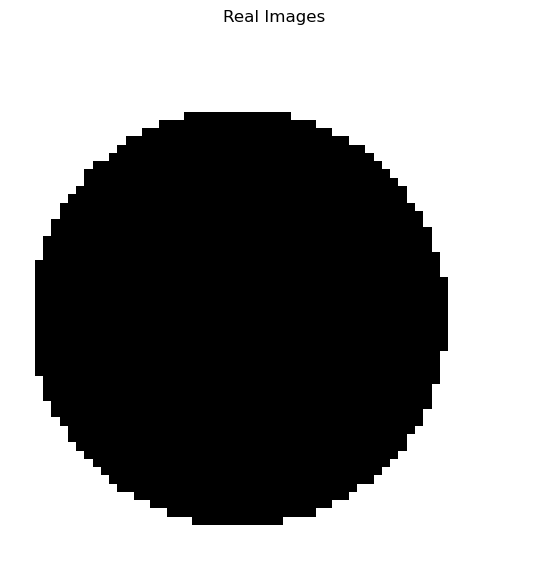

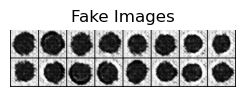

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.savefig('outputs/dcgan/realImages.png')
plt.show()

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('outputs/dcgan/fakeImages.png')
plt.show()

[[[0.00985752]]]


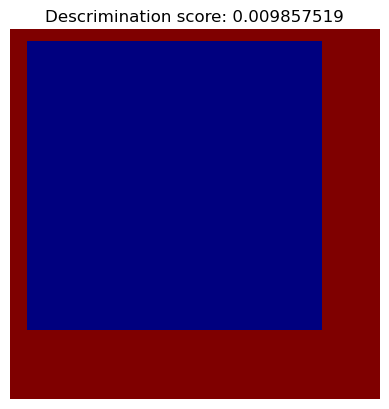

[[[0.9046643]]]


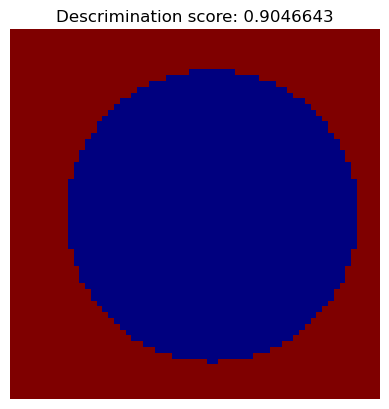

In [17]:
# load squared data
false_data = torch.load('data/squareData64.pt')
false_dataset = microstructureDataset(false_data[1:12800])

false_batch = false_dataset[1:16].to(device)
descrimination = netD(false_batch).detach().cpu().numpy()
print(descrimination[0])

# plot false batch and write descrimination in title
plt.figure()
plt.axis("off")
plt.title(f"Descrimination score: " + str(descrimination[0].squeeze()))
plt.imshow(np.transpose(false_batch[0].cpu(), (1, 2, 0)), cmap='jet')
plt.savefig('outputs/dcgan/test_D_with_false_image.png')
plt.show()

# plot real batch and write descrimination in title
real_batch = next(iter(dataloader))
descrimination = netD(real_batch.to(device)).detach().cpu().numpy()
print(descrimination[0])  

plt.figure()
plt.axis("off")
plt.title(f"Descrimination score: " + str(descrimination[0].squeeze()))
plt.imshow(np.transpose(real_batch[0].cpu(), (1, 2, 0)), cmap='jet')
plt.savefig('outputs/dcgan/test_D_with_real_image.png')
plt.show()